<a href="https://colab.research.google.com/github/AmirHoseinTaherkhani/Miros/blob/main/TimeSeries_Week4Exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
import tensorflow as tf
print(tf.__version__)

2.4.1


In [3]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [4]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv \
    -O /tmp/daily-min-temperatures.csv

--2021-05-15 09:20:44--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67921 (66K) [text/plain]
Saving to: ‘/tmp/daily-min-temperatures.csv’

/tmp/daily-min-temp 100%[===================>]  66.33K  --.-KB/s    in 0.008s  

2021-05-15 09:20:44 (7.70 MB/s) - ‘/tmp/daily-min-temperatures.csv’ saved [67921/67921]



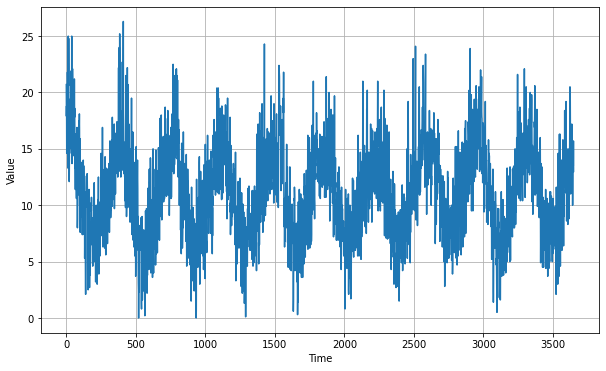

In [10]:
import csv
time_step = []
temps = []

with open('/tmp/daily-min-temperatures.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  step=0
  for row in reader:
    temps.append(float(row[1]))
    time_step.append(step)
    step = step + 1

series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [17]:
import pandas as pd
df = pd.read_csv('/tmp/daily-min-temperatures.csv')
df.head()

,Date,Temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


In [19]:
split_time = 2500
time_train = time_step[:split_time]
x_train = series[:split_time]
time_valid = time_step[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000


In [20]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [21]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [26]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
tf.keras.layers.Conv1D(filters=32, kernel_size=5, strides=1, padding="causal", activation="relu", input_shape=[None, 1]),



tf.keras.layers.LSTM(64,return_sequences=True),
tf.keras.layers.LSTM(64,return_sequences=True),
tf.keras.layers.Dense(30, activation='relu'),
tf.keras.layers.Dense(10, activation='relu'),
tf.keras.layers.Dense(1),
tf.keras.layers.Lambda(lambda x:x*400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(2500,)
Epoch 1/100
10/10 [==============================] - 35s 34ms/step - loss: 31.0287 - mae: 31.5267
Epoch 2/100
10/10 [==============================] - 0s 30ms/step - loss: 30.7697 - mae: 31.2675
Epoch 3/100
10/10 [==============================] - 0s 31ms/step - loss: 29.9371 - mae: 30.4346
Epoch 4/100
10/10 [==============================] - 0s 31ms/step - loss: 28.6752 - mae: 29.1725
Epoch 5/100
10/10 [==============================] - 0s 31ms/step - loss: 27.2988 - mae: 27.7959
Epoch 6/100
10/10 [==============================] - 0s 32ms/step - loss: 25.7600 - mae: 26.2569
Epoch 7/100
10/10 [==============================] - 0s 32ms/step - loss: 24.0420 - mae: 24.5383
Epoch 8/100
10/10 [==============================] - 0s 33ms/step - loss: 21.3711 - mae: 21.8673
Epoch 9/100
10/10 [==============================] - 0s 31ms/step - loss: 18.2363 - mae: 18.7316
Epoch 10/100
10/10 [====

(1e-08, 0.0001, 0.0, 60.0)

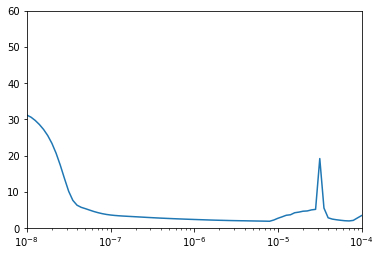

In [27]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [29]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
tf.keras.layers.Conv1D(filters=32, kernel_size=5, strides=1, padding="causal", activation="relu", input_shape=[None, 1]),
tf.keras.layers.LSTM(64,return_sequences=True),
tf.keras.layers.LSTM(64,return_sequences=True),
tf.keras.layers.Dense(30, activation='relu'),
tf.keras.layers.Dense(10, activation='relu'),
tf.keras.layers.Dense(1),
tf.keras.layers.Lambda(lambda x:x*400)
])

optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=50)
                                    
# EXPECTED OUTPUT SHOULD SEE AN MAE OF <2 WITHIN ABOUT 30 EPOCHS

Epoch 1/50
25/25 [==============================] - 3s 16ms/step - loss: 17.2200 - mae: 17.7137
Epoch 2/50
25/25 [==============================] - 1s 18ms/step - loss: 3.1158 - mae: 3.5857
Epoch 3/50
25/25 [==============================] - 1s 16ms/step - loss: 2.1051 - mae: 2.5624
Epoch 4/50
25/25 [==============================] - 1s 17ms/step - loss: 1.9467 - mae: 2.3999
Epoch 5/50
25/25 [==============================] - 1s 16ms/step - loss: 1.8791 - mae: 2.3310
Epoch 6/50
25/25 [==============================] - 1s 18ms/step - loss: 1.8361 - mae: 2.2874
Epoch 7/50
25/25 [==============================] - 1s 17ms/step - loss: 1.8288 - mae: 2.2806
Epoch 8/50
25/25 [==============================] - 1s 16ms/step - loss: 1.8199 - mae: 2.2717
Epoch 9/50
25/25 [==============================] - 1s 17ms/step - loss: 1.8674 - mae: 2.3207
Epoch 10/50
25/25 [==============================] - 1s 17ms/step - loss: 1.7775 - mae: 2.2278
Epoch 11/50
25/25 [==============================] - 1s 1

In [30]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

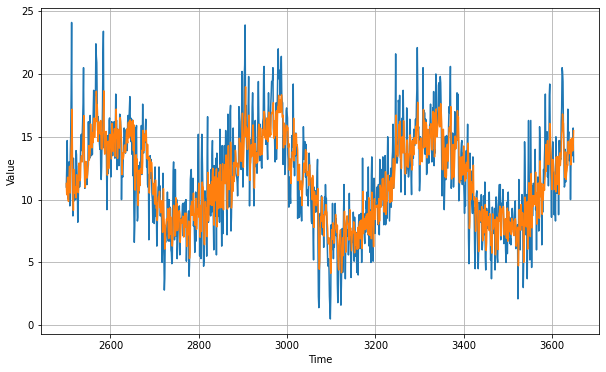

In [31]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

# EXPECTED OUTPUT. PLOT SHOULD SHOW PROJECTIONS FOLLOWING ORIGINAL DATA CLOSELY

In [32]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

# EXPECTED OUTPUT MAE < 2 -- I GOT 1.789626

1.8122325

In [33]:
print(rnn_forecast)
# EXPECTED OUTPUT -- ARRAY OF VALUES IN THE LOW TEENS

[11.278972 10.387623 11.094848 ... 13.871464 14.134234 15.487516]
